In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import pandas as pd

Italian data downloaded from: https://github.com/pcm-dpc/COVID-19

Table has been slightly modified and are updated till April 07, 2022.

## Italian data

In [ ]:
nep = Table.read('Data_Italy.csv',format='ascii.csv')
nep

Date,Hospitalised,In ICU,All Hospitalised,Home Isolation,Infected,Delta Infected,New Infected,Healed,Dead,casi_da_sospetto_diagnostico,casi_da_screening,All Infected,Test,casi_testati,ingressi_terapia_intensiva,note_test,note_casi,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido,DOrd
str19,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
2020-02-24T18:00:00,101,26,127,94,221,0,221,1,7,--,--,229,4324,--,--,--,--,--,--,--,--,55
2020-02-25T18:00:00,114,35,150,162,311,90,93,1,10,--,--,322,8623,--,--,--,--,--,--,--,--,56
2020-02-26T18:00:00,128,36,164,221,385,74,78,3,12,--,--,400,9587,--,--,--,--,--,--,--,--,57
2020-02-27T18:00:00,248,56,304,284,588,203,250,45,17,--,--,650,12014,--,--,--,--,--,--,--,--,58
2020-02-28T18:00:00,345,64,409,412,821,233,238,46,21,--,--,888,15695,--,--,--,--,--,--,--,--,59
2020-02-29T18:00:00,401,105,506,543,1049,228,240,50,29,--,--,1128,18661,--,--,--,--,--,--,--,--,60
2020-03-01T18:00:00,639,140,779,798,1577,528,566,83,34,--,--,1694,21127,--,--,--,--,--,--,--,--,61
2020-03-02T18:00:00,742,166,908,927,1835,258,342,149,52,--,--,2036,23345,--,--,--,--,--,--,--,--,62
2020-03-03T18:00:00,1034,229,1263,1000,2263,428,466,160,79,--,--,2502,25856,--,--,--,--,--,--,--,--,63


Let's compute the number of deaths per day in Italy.

In [ ]:
dDead = [nep['Dead'][i+1]-nep['Dead'][i] for i in range(len(nep)-1)]
dDead.insert(0,nep['Dead'][0])
dDead = np.array(dDead)

### Italian data plot

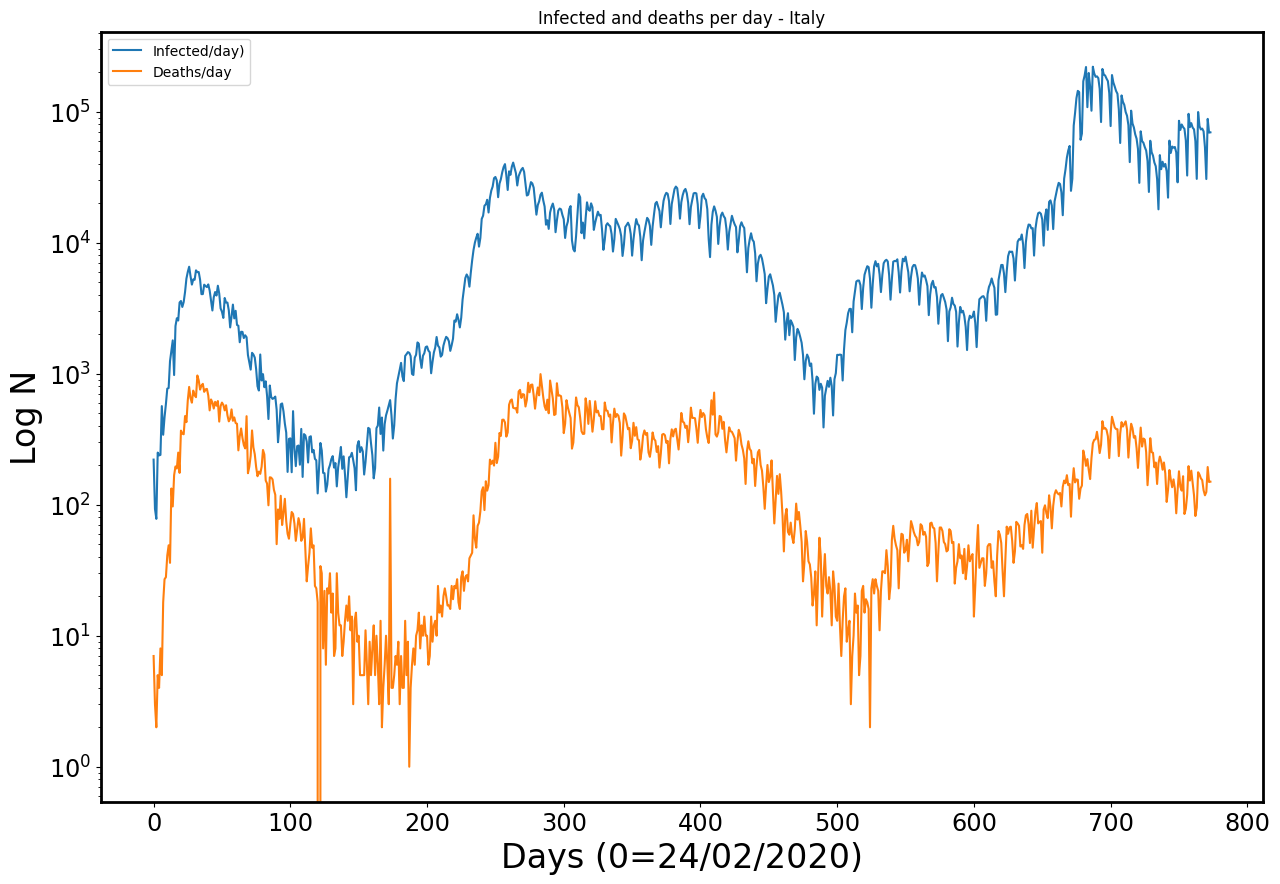

In [ ]:
p = plt.figure(figsize=(15,10))
px = p.add_subplot(111)
[i.set_linewidth(2) for i in px.spines.values()]
#
plt.tick_params(axis='both', which='major', labelsize='xx-large')
plt.tick_params(axis='both', which='minor', labelsize='x-large')
#
plt.plot(nep['New Infected'],label='Infected/day)')
plt.plot(dDead,label='Deaths/day')
plt.semilogy()
title = "Infected and deaths per day - Italy"
plt.legend()
plt.title(title)
plt.xlabel("Days (0=24/02/2020)",fontsize=24)
plt.ylabel("Log N",fontsize=24);
#plt.savefig("{}.pdf".format(title))

## Cross correlation between the Infected/day and Deaths/day data

Let's try with pandas tools.

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation.
    Shifted data filled with NaNs

    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else:
        return datax.corr(datay.shift(lag))


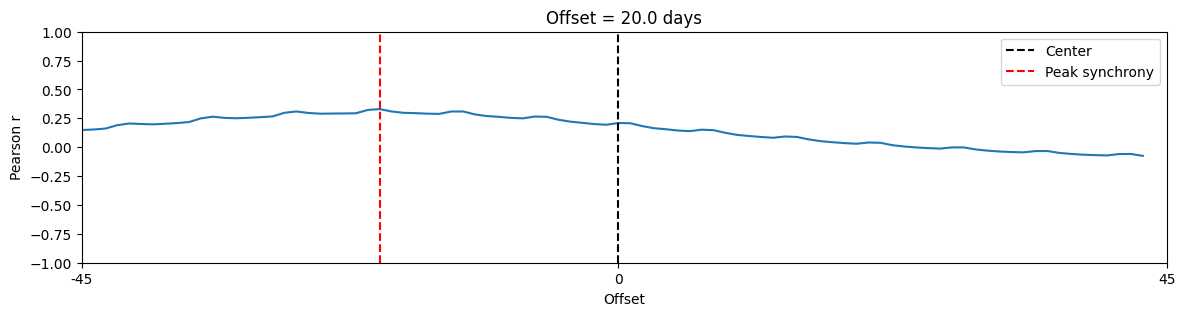

In [ ]:
d = {'ninf':nep['New Infected'], "dead":dDead}
df = pd.DataFrame(data=d)

AL = 20
DL = -len(nep)
d1 = df['ninf'][AL:-DL]
d2 = df['dead'][AL:-DL]

rs = [crosscorr(d1,d2, lag) for lag in range(-45,45)]
offset = np.ceil(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')

ax.set(title=f'Offset = {offset} days',ylim=[-1,1.],xlim=[0,90], xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 45, 91])
ax.set_xticklabels([-45, 0, 45]);
#plt.xlim((0,90))
plt.legend()
#plt.savefig('cross-correlation-ITA.pdf')

Or even with stingray.

In [ ]:
!pip install stingray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 10.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
from stingray import Lightcurve
from stingray.crosscorrelation import CrossCorrelation

import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
%matplotlib inline
font_prop = font_manager.FontProperties(size=16)

In [ ]:
lc1ITA = Lightcurve(nep['DOrd'][20:], nep['New Infected'][20:])
lc2ITA = Lightcurve(nep['DOrd'][20:], dDead[20:])

In [ ]:
cr = CrossCorrelation(lc1ITA, lc2ITA)
# Let's find the maximum in the cross-correlation data
mm = np.argmax(cr.corr[cr.time_lags < 100])
# And the related lag
mt = cr.time_lags[cr.time_lags < 100][mm]
print("Maximum correlation at lag {} days".format(mt))

Maximum correlation at lag -20.0 days


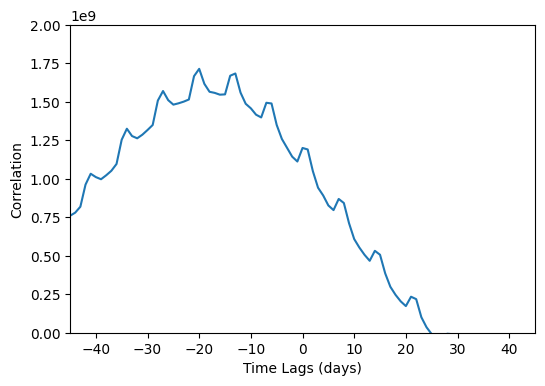

<Axes: xlabel='Time Lags (days)', ylabel='Correlation'>

In [ ]:
cr.plot(labels = ['Time Lags (days)','Correlation'], axis=[-45, 45, -5, 2e9])

## Seasonal periodicity?

In [ ]:
from astropy.timeseries import LombScargle as LS
freq,power = LS(nep['DOrd'][20:], nep['New Infected'][20:]).autopower(minimum_frequency=1/700,maximum_frequency=1/2,samples_per_peak=10)

Text(0, 0.5, 'Power')

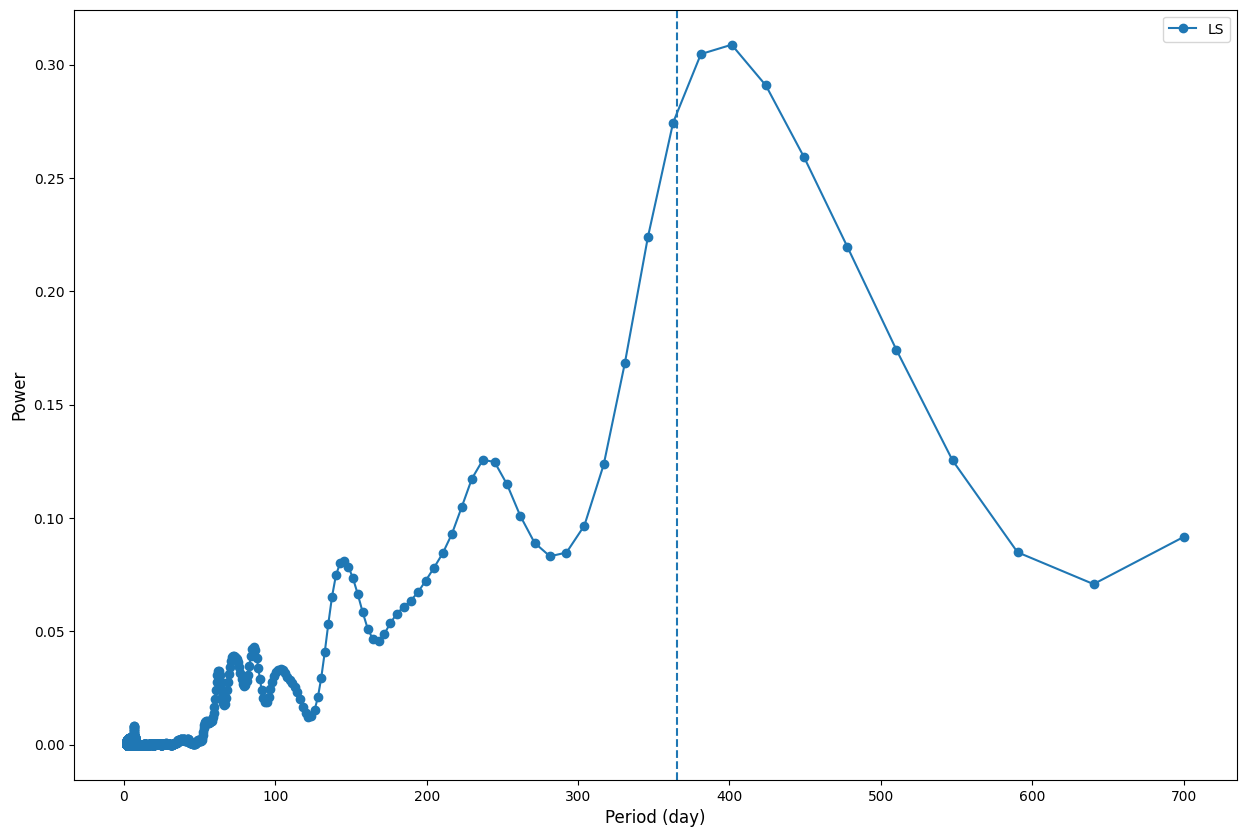

In [ ]:
p = plt.figure(figsize=(15,10))
plt.plot(1./freq,power,'o-',label='LS')
plt.legend()
plt.axvline(365.25,ls='--')
plt.xlabel("Period (day)",fontsize='large')
plt.ylabel("Power",fontsize='large')

## One week periodicity in the data?

In [ ]:
from astropy.timeseries import LombScargle as LS
freq,power = LS(nep['DOrd'][20:], nep['New Infected'][20:]).autopower(minimum_frequency=1/30,maximum_frequency=1/2,samples_per_peak=10)

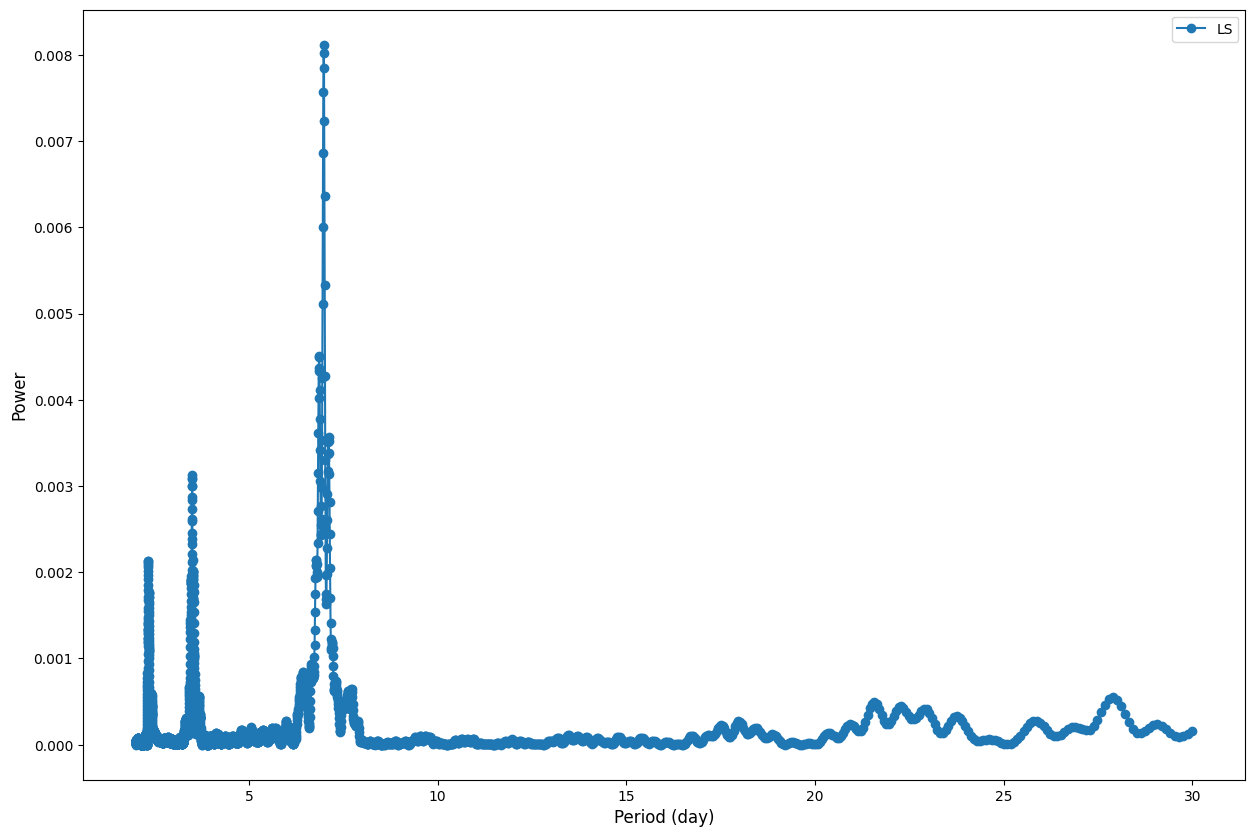

In [ ]:
p = plt.figure(figsize=(15,10))
plt.plot(1./freq,power,'o-',label='LS')
plt.legend()
plt.xlabel("Period (day)",fontsize='large')
plt.ylabel("Power",fontsize='large');

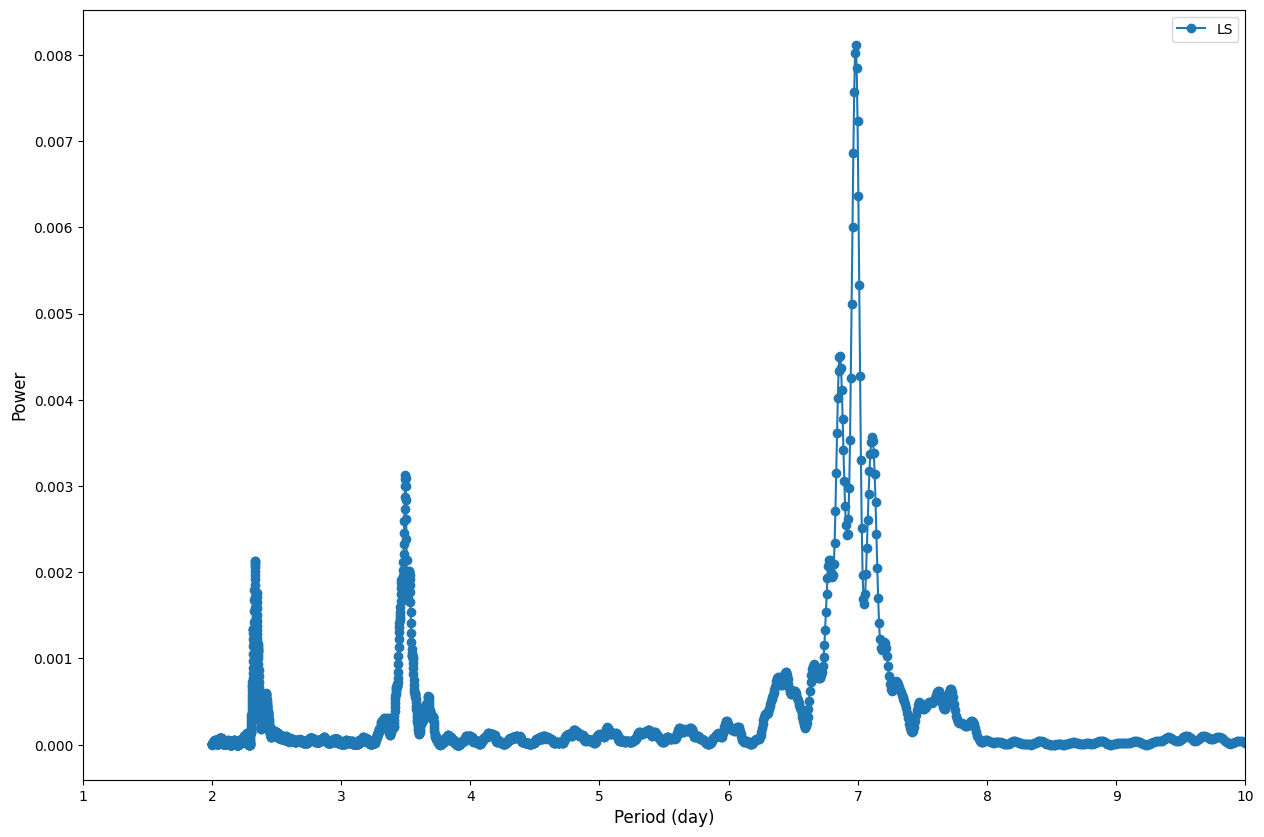

In [ ]:
p = plt.figure(figsize=(15,10))
plt.plot(1./freq,power,'o-',label='LS')
plt.legend()
plt.xlabel("Period (day)",fontsize='large')
plt.ylabel("Power",fontsize='large')
plt.xlim((1,10))
plt.show()